### 針對 Steam《Apex Legends》玩家評論之分析
課程：社群媒體分析

授課教授：黃三益老師

組別：Group_7

組員：

B104020019 黃婕妮

B104020023 蔡宜樺

M134020005 馮祐倫

M134020021 李翊曲

M134020030 戴廣琛

M134020046 宋旻家

M134610017 李逸華


大綱


1. 資料前處理

   1.1 資料匯入

   1.2 資料清理、斷詞、還原詞幹

2. 文辭和文件分析

   2.1 Bigram

   2.2 共線相關圖

3. Pairwise correlation

   3.1 和 matchmak, linux 相關性最高的 8 個詞彙

4. 字詞分類
   
   4.1 分類遊戲內容以及遊戲管理

   4.2 根據7:3的比例切分資料集

   4.3 模型評估

   4.4 分析可解釋模型的結果

5. 主題模型

   5.1 人工給定主題的主題模型

   5.2 LDA主題模型前處理

   5.3 訓練 LDA topic model

   5.4 查看 LDA 模型指標找出最佳主題數

   5.5 視覺化呈現

6. 結論、困難點與不足

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import nltk
#nltk.download("punkt")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import math
from nltk import ngrams
from nltk import FreqDist
from collections import Counter, namedtuple
import time

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.matutils import corpus2csc
import pyLDAvis
import pyLDAvis.gensim_models

## **1. 資料前處理**

### 1.1 資料匯入

In [3]:
#匯入資料
MetaData = pd.read_csv('D:\社媒\Reviews_After_tokenize_1800.csv')
MetaData.head()

<>:2: DeprecationWarning: invalid escape sequence '\R'
<>:2: DeprecationWarning: invalid escape sequence '\R'
C:\Users\Tak\AppData\Local\Temp\ipykernel_16536\3324918418.py:2: DeprecationWarning: invalid escape sequence '\R'
  MetaData = pd.read_csv('D:\社媒\Reviews_After_tokenize_1800.csv')


,isRecommended,Content,Date,isUseful,sentence,terms,token,word,stem_token
0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,2 10 dollar battle passes per seasonTitanfall ...,2,2,2
1,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,2 10 dollar battle passes per seasonTitanfall ...,10,10,10
2,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,2 10 dollar battle passes per seasonTitanfall ...,dollar,dollar,dollar
3,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,2 10 dollar battle passes per seasonTitanfall ...,battle,battle,battl
4,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,2 10 dollar battle passes per seasonTitanfall ...,passes,passes,pass


### 1.2 資料清理、斷詞、還原詞幹

In [4]:
# 設定斷詞 function
##新增stop words
nltk.download('stopwords')
stopWords = stopwords.words('english')
stemmer = PorterStemmer() #做Stemming還原詞幹

def getToken(row):
    seg_list = nltk.tokenize.word_tokenize(row)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    return seg_list

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
tp_df = MetaData.copy()

tp_df = tp_df.drop(['isUseful', 'terms', 'token', 'word'], axis= 1)
tp_df.rename(columns={'stem_token': 'word'}, inplace=True)
tp_df['sentence'] = tp_df['Content'].str.replace(r'\n\n',' ', regex=True)
tp_df['sentence'] = tp_df['sentence'].str.replace(r'[^A-Za-z\s]', '', regex=True)
tp_df = tp_df.drop_duplicates(subset='sentence').reset_index()

#保留年月
tp_df['Date'] = pd.to_datetime(tp_df['Date'], format='%Y-%m-%d')
tp_df['Date'] = tp_df['Date'].dt.strftime('%Y-%m')

# 需要改成使用空格連接斷好的詞
tp_df['word'] = tp_df.sentence.apply(getToken).map(' '.join)
tp_df




,index,isRecommended,Content,Date,sentence,word
0,0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-07,dollar battle passes per season Titanfall di...,dollar battl pass per season titanfal die slop
1,9,不推薦,"Now with the new battle pass system, I'm delet...",2024-07,Now with the new battle pass system Im deletin...,new battl pass system im delet game well playe...
2,19,不推薦,Game freezes every session i play with the new...,2024-06,Game freezes every session i play with the new...,game freez everi session play new updat liter ...
3,28,不推薦,"Apex is like your neighbor's sister, she treat...",2024-07,Apex is like your neighbors sister she treats ...,apex like neighbor sister treat utmost tender ...
4,63,不推薦,It's very sad. It's like saying good bye to a ...,2025-01,Its very sad Its like saying good bye to a lon...,sad like say good bye longtim friend friend le...
...,...,...,...,...,...,...
1806,24208,不推薦,"Eh, would like to recommend, but its eh. EA is...",2024-10,Eh would like to recommend but its eh EA is to...,eh would like recommend eh ea money hungri
1807,24217,不推薦,Save yourself from the pain of this game. Go d...,2024-10,Save yourself from the pain of this game Go do...,save pain game go download game steam fun dont...
1808,24232,不推薦,rest in piece,2024-09,rest in piece,rest piec
1809,24234,不推薦,poo poo,2024-08,poo poo,poo poo


## **2. 文辭和文件分析**

### 2.1 Bigram

In [8]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = nltk.tokenize.word_tokenize(row)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [9]:
tp_bigram = tp_df.copy()
tp_bigram["word"] = tp_bigram.sentence.apply(bigram_getToken)
tp_bigram = tp_bigram.explode('word')
tp_bigram

,index,isRecommended,Content,Date,sentence,word
0,0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-07,dollar battle passes per season Titanfall di...,dollar battl
0,0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-07,dollar battle passes per season Titanfall di...,battl pass
0,0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-07,dollar battle passes per season Titanfall di...,pass per
0,0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-07,dollar battle passes per season Titanfall di...,per season
0,0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-07,dollar battle passes per season Titanfall di...,season titanfal
...,...,...,...,...,...,...
1809,24234,不推薦,poo poo,2024-08,poo poo,poo poo
1810,24236,不推薦,ea is just botting to keep their game alive,2024-08,ea is just botting to keep their game alive,ea bot
1810,24236,不推薦,ea is just botting to keep their game alive,2024-08,ea is just botting to keep their game alive,bot keep
1810,24236,不推薦,ea is just botting to keep their game alive,2024-08,ea is just botting to keep their game alive,keep game


In [10]:
# 計算每個組合出現的次數
tp_bigram_count = tp_bigram.groupby(['Date',"word"],as_index=False).size()
tp_bigram_count.sort_values(by=['size'], ascending=False).head(15)

,Date,word,size
115,2024-03,crash crash,647
2909,2024-07,battl pass,125
14668,2024-11,linux support,96
15381,2024-11,remov linux,46
7190,2024-07,play game,37
15134,2024-11,play game,36
15656,2024-11,steam deck,34
6762,2024-07,new battl,32
14675,2024-11,linux user,30
8632,2024-07,thi game,25


相關性最高的 terms: 
因為battle pass收費政策在預告推出不久後就因為反彈聲浪過大而取消，而該政策在7月預告推出後並沒有造成更嚴重的玩家下滑，因此我們針對除了battle pass之外的議題去看還有哪些因素造成玩家流失
Top 2：fix 與 matchmak
 「matchmak」應為「matchmaking」的詞性還原結果，與「fix」一詞共同出現，暗示玩家普遍關注配對系統的問題。這是遊戲評論中常見的抱怨組合，例如：「please fix the matchmaking system」。此組詞顯示出玩家對競技平衡、公平配對與技術穩定性的強烈期待與要求。
在 Top 3 關鍵詞群之外，出現頻率較高的字詞包括「linux」、「support」、「remove」、「user」。結合先前的視覺化圖表與相關討論，可以推測這些詞彙反映了Apex Legends 官方在新聞事件中宣布停止支援 Linux 環境的爭議。
具體來說，由於部分 Linux 環境下的玩家被誤判為作弊行為的來源（如使用非官方相容層或修改過的系統設定），導致該平台逐步被移除支援，進而引起使用者（user）不滿與技術性回饋。詞語如「remove」與「support」也正好反映了這段過程。


In [58]:
#根據剛剛的觀察可以增加stopwords
stopWords.extend(['thi', 'apex', 'legend', 'royal','still','game','titanfal'])

In [59]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = nltk.tokenize.word_tokenize(row)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [60]:
fud_bigram2 = tp_df.copy()
fud_bigram2["word"] = fud_bigram2.sentence.apply(bigram_getToken_dict)
fud_bigram2 = fud_bigram2.explode('word')
fud_bigram2.head(3)

,index,isRecommended,Content,Date,sentence,word
0,0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-07,dollar battle passes per season Titanfall di...,dollar battl
0,0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-07,dollar battle passes per season Titanfall di...,battl pass
0,0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-07,dollar battle passes per season Titanfall di...,pass per


統計出前五常出現的bigram組合

In [61]:
# 看一下bigramfdist內容
bigramfdist.most_common(5)

[(('crash', 'crash'), 647),
 (('battl', 'pass'), 143),
 (('linux', 'support'), 102),
 (('remov', 'linux'), 48),
 (('steam', 'deck'), 39)]

統計出前30常出現的bigram組合

In [62]:
# 建立bigram和count的dictionary
# 這裡取最多的前30項
d = {k:v for k,v in bigramfdist.most_common(30)}
d

{('crash', 'crash'): 647,
 ('battl', 'pass'): 143,
 ('linux', 'support'): 102,
 ('remov', 'linux'): 48,
 ('steam', 'deck'): 39,
 ('new', 'battl'): 34,
 ('linux', 'user'): 33,
 ('player', 'base'): 32,
 ('dont', 'play'): 27,
 ('aim', 'assist'): 25,
 ('cant', 'play'): 24,
 ('play', 'sinc'): 23,
 ('anti', 'cheat'): 23,
 ('dont', 'even'): 23,
 ('dont', 'care'): 21,
 ('feel', 'like'): 20,
 ('bring', 'back'): 20,
 ('block', 'linux'): 20,
 ('pass', 'system'): 18,
 ('cash', 'grab'): 18,
 ('gon', 'na'): 17,
 ('support', 'linux'): 17,
 ('instead', 'fix'): 17,
 ('drop', 'linux'): 17,
 ('ea', 'respawn'): 16,
 ('new', 'player'): 16,
 ('get', 'wors'): 15,
 ('fix', 'matchmak'): 15,
 ('pass', 'chang'): 15,
 ('spend', 'money'): 15}

### 2.2 共線相關圖

In [63]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.05 for w in  G.edges(data=True)]

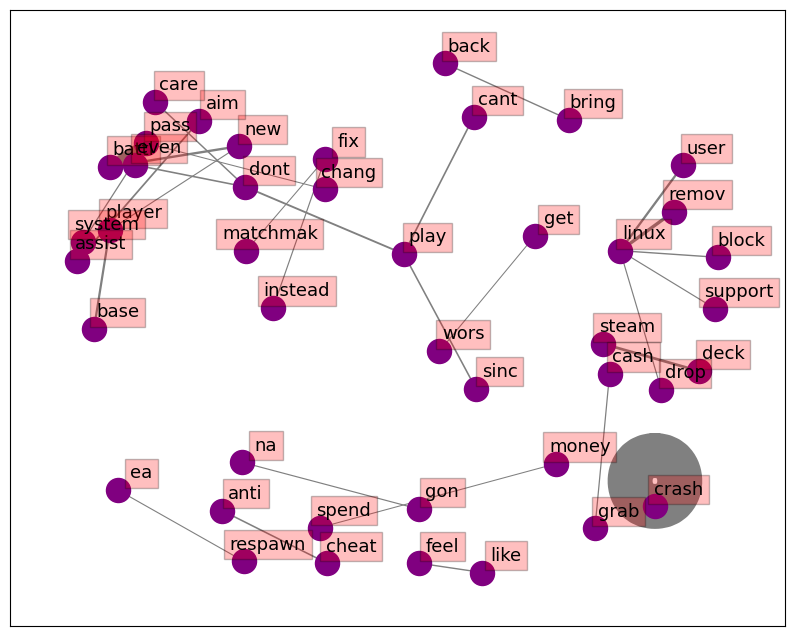

In [105]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

技術問題與系統
關鍵詞：steam deck、linux、support、remove、fix、crash、die
說明：此群組與玩家遇到的技術性與平台問題有關。包括遊戲的執行錯誤（crash），官方停止支援 Linux 的討論（remove）等

遊戲公平性
關鍵詞：matchmak、aim assist
說明：這個群組說明玩家在遊玩中那些體驗是不好的，原因大多來自對手實力分配不均勻，會遇到跟自己實力不符合的玩家。另外，apex中的遊玩方式分為鍵盤滑鼠與遊戲手把，而遊戲手把比鍵盤滑鼠多出一項功能叫aim assist(輔助自動瞄準)，這也是造成遊戲不公平的議題之一

遊戲公司及其政策相關
關鍵詞：dont、respawn、ea、user、battle pass、money
說明：可以看到出現了遊戲公司、戰鬥通行證、錢等

作弊與反外掛系統
關鍵詞：cheat、wors、anti
說明：此群體反映玩家對於作弊現象與反外掛系統（anti-cheat）的不滿，例如懷疑反外掛系統效能差、對 cheater 抑制無力等。




## 3. Pairwise correlation

In [118]:
data_cor = tp_df.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor

,index,isRecommended,Content,Date,sentence,word
0,0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-07,dollar battle passes per season Titanfall di...,dollar battl pass per season die slop
1,9,不推薦,"Now with the new battle pass system, I'm delet...",2024-07,Now with the new battle pass system Im deletin...,new battl pass system im delet well player bye
2,19,不推薦,Game freezes every session i play with the new...,2024-06,Game freezes every session i play with the new...,freez everi session play new updat liter unplay
3,28,不推薦,"Apex is like your neighbor's sister, she treat...",2024-07,Apex is like your neighbors sister she treats ...,like neighbor sister treat utmost tender bring...
4,63,不推薦,It's very sad. It's like saying good bye to a ...,2025-01,Its very sad Its like saying good bye to a lon...,sad like say good bye longtim friend friend le...
...,...,...,...,...,...,...
1806,24208,不推薦,"Eh, would like to recommend, but its eh. EA is...",2024-10,Eh would like to recommend but its eh EA is to...,eh would like recommend eh ea money hungri
1807,24217,不推薦,Save yourself from the pain of this game. Go d...,2024-10,Save yourself from the pain of this game Go do...,save pain go download steam fun dont care down...
1808,24232,不推薦,rest in piece,2024-09,rest in piece,rest piec
1809,24234,不推薦,poo poo,2024-08,poo poo,poo poo


In [119]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 100)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,also,anticheat,anymor,ass,back,bad,ban,base,battl,battlepass,...,updat,use,user,want,way,well,work,wors,would,year
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1806,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1807,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1808,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1809,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,also,anticheat,anymor,ass,back,bad,ban,base,battl,...,updat,use,user,want,way,well,work,wors,would,year
0,also,1.000000,0.033588,-0.009670,-0.000478,0.072622,0.092010,0.171833,0.092704,0.150933,...,0.054655,0.068760,-0.021366,0.053630,0.147728,0.020281,0.101202,-0.004640,0.119893,0.140312
1,anticheat,0.033588,1.000000,0.032868,-0.006347,0.017244,0.037759,0.180011,-0.009104,-0.012831,...,0.028475,0.053375,0.098906,-0.037671,0.012305,0.012570,0.143286,0.006390,0.002459,-0.031601
2,anymor,-0.009670,0.032868,1.000000,-0.010120,0.033846,0.016381,0.007573,0.034761,0.074919,...,0.007389,0.116374,-0.012535,0.077240,0.059031,0.042488,0.038376,-0.013258,-0.002836,0.066107
3,ass,-0.000478,-0.006347,-0.010120,1.000000,-0.033397,-0.034041,0.023990,0.016385,-0.022840,...,-0.010384,-0.038282,-0.004592,-0.003832,0.065387,0.021226,-0.003579,-0.004857,0.029717,-0.012436
4,back,0.072622,0.017244,0.033846,-0.033397,1.000000,0.038765,0.063854,0.033265,0.066259,...,0.062304,0.083046,0.039241,0.120756,0.040442,0.026365,0.036850,0.053832,0.024735,0.076001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,well,0.020281,0.012570,0.042488,0.021226,0.026365,-0.006371,0.038266,0.014608,0.033890,...,0.021177,0.119855,-0.005387,0.009168,0.082819,1.000000,0.037336,0.030254,0.008871,0.032549
96,work,0.101202,0.143286,0.038376,-0.003579,0.036850,-0.022347,0.082141,-0.006539,0.056601,...,0.002487,0.099247,0.025580,0.102379,0.077557,0.037336,1.000000,0.044330,-0.011452,0.058142
97,wors,-0.004640,0.006390,-0.013258,-0.004857,0.053832,-0.010251,-0.027186,-0.023271,0.013726,...,0.106767,0.017133,-0.021743,0.038076,-0.023174,0.030254,0.044330,1.000000,0.003245,0.085512
98,would,0.119893,0.002459,-0.002836,0.029717,0.024735,0.054318,0.065564,0.053740,0.031794,...,0.091141,0.033892,0.017354,0.106054,0.098346,0.008871,-0.011452,0.003245,1.000000,0.044484


In [121]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
862,pass,battl,0.872878
6208,battl,pass,0.872878
8023,deck,steam,0.788779
2380,steam,deck,0.788779
5633,fix,matchmak,0.636917
3356,matchmak,fix,0.636917
5183,support,linux,0.506922
8351,linux,support,0.506922
8370,remov,support,0.433554
7083,support,remov,0.433554


### 3.1 和 matchmak, linux 相關性最高的 8 個詞彙

In [125]:
d_sum = word_cor_df[(word_cor_df["word1"]=="matchmak")].sort_values(by=['cor'], ascending = False).head(8)
m_sum = word_cor_df[(word_cor_df["word1"]=="linux")].sort_values(by=['cor'], ascending = False).head(8)

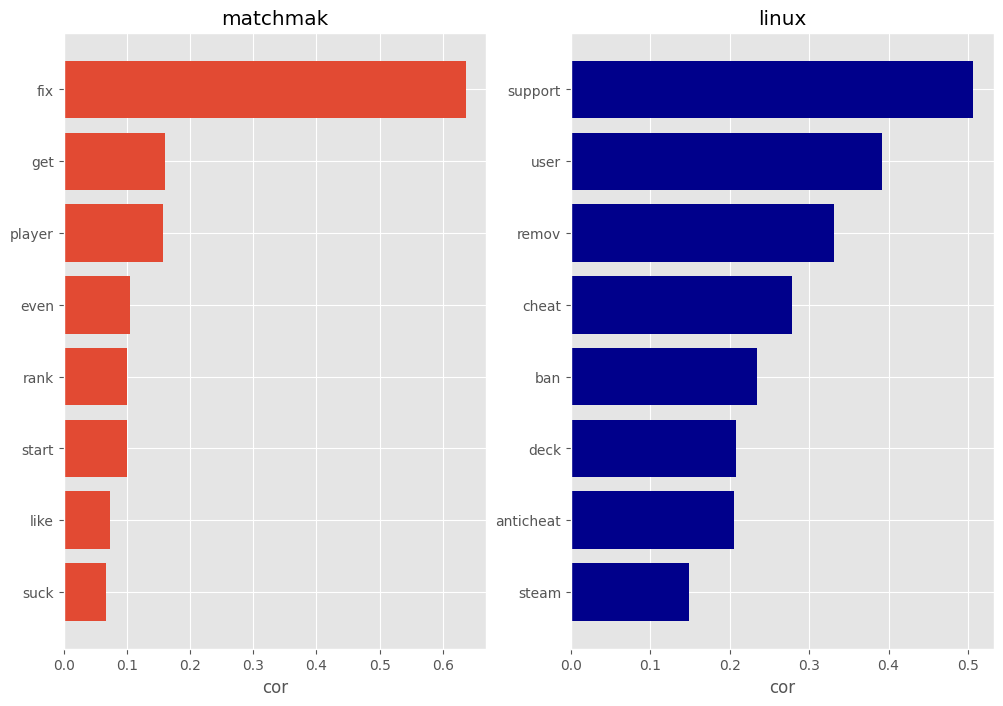

In [126]:
d_sum = d_sum.sort_values(by=['cor'])
m_sum = m_sum.sort_values(by=['cor'])

plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
# plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('matchmak')
plt.xlabel('cor')
plt.barh(d_sum['word2'],d_sum['cor'])

plt.subplot(122)
plt.title('linux')
plt.xlabel('cor')
plt.barh(m_sum['word2'],m_sum['cor'],color="darkblue")


plt.show()

在 biagram 圖表中，選取了 matchmak 和 linux 兩個作為討論主題。

matchmake 的關聯詞包含fix、rank、suck等，可以看出玩家對於目前排位機制並沒有很滿意，並希望官方解決這個問題
linux 的關聯詞包含 support、remove、cheat、anticheat、steam 等，表現了玩家對官方支援與反作弊系統處理方式的關注。
這些關聯結果其實可以與去年的新聞事件直接對應，EA 宣布《APEX 英雄》將停止支援 Steam Deck 與 Linux 系統，理由就是因為這些環境被認為是作弊程式的溫床。官方提到，儘管使用了自動偵測使用者電腦上是否有安裝作弊程式的系統，仍無法有效防範透過 Linux 核心繞過驗證的作弊行為，甚至有些作弊者會刻意模擬成 Linux 環境來逃避偵測。

## 4. 字詞分類

In [1]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold, GridSearchCV
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [6]:
rec = tp_df.copy()
test = rec['word'].fillna('').astype(str).tolist()



### 4.1 分類遊戲內容以及遊戲管理
這邊根據前面字詞共現圖的分群主題，根據觀察後用bert將評論分類成遊戲內容以及遊戲管理

In [ ]:
#提供關鍵字
anchor_content = "matchmake , aim assist, cheat, crash, play"
anchor_management = "anticheat, paid, server, linux, ea, respawn, battle pass, season"

from transformers import BertTokenizer, BertModel
import torch
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# 初始化 BERT 模型
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.pooler_output.squeeze().numpy()  # 取 [CLS] 向量

# 編碼 anchor vectors
vec_content = get_bert_embedding(anchor_content)
vec_management = get_bert_embedding(anchor_management)

def classify_comment(text):
    vec = get_bert_embedding(text)
    sim_content = cosine_similarity([vec], [vec_content])[0][0]
    sim_management = cosine_similarity([vec], [vec_management])[0][0]
    return "Game Content" if sim_content > sim_management else "Game Management"

rec['cluster'] = rec['sentence'].apply(classify_comment)


In [8]:
rec['cluster'].value_counts()

cluster
Game Management    1123
Game Content        688
Name: count, dtype: int64

### 4.2 根據7:3的比例切分資料集

In [9]:
data = rec.copy()
X = data["sentence"]
y = data["cluster"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

X_train.head()

1665                    Positive feedback is now paid for
337     Game has been going downhill for a while They ...
718     A good game filled with microtransactions and ...
354     My calculator is more advanced than their servers
1497                   EA is being EA and ruin everything
Name: sentence, dtype: object

In [10]:
y_train.head()

1665    Game Management
337        Game Content
718        Game Content
354     Game Management
1497       Game Content
Name: cluster, dtype: object

### 4.3 模型評估

                 precision    recall  f1-score   support

   Game Content       0.81      0.64      0.72       484
Game Management       0.80      0.91      0.85       783

       accuracy                           0.81      1267
      macro avg       0.81      0.77      0.78      1267
   weighted avg       0.81      0.81      0.80      1267



c:\Users\Tak\anaconda3\envs\SMA\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\Tak\anaconda3\envs\SMA\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\Tak\anaconda3\envs\SMA\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


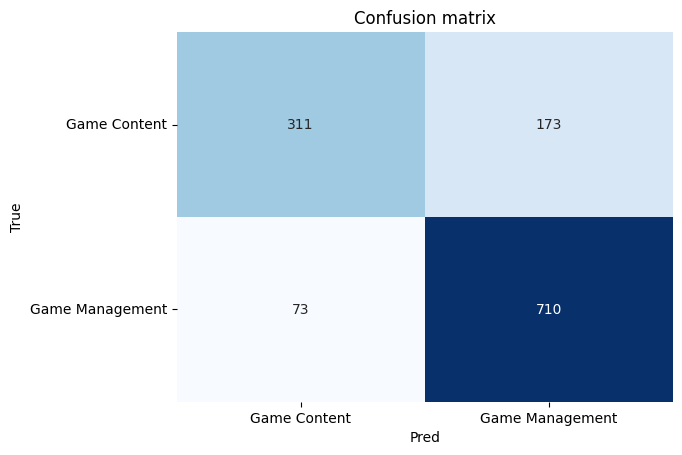

In [11]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")

    # one-hot encoding
    enc = OneHotEncoder(sparse_output=False)
    enc.fit(y.values.reshape(-1, 1))
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title="Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

vectorizer = CountVectorizer(max_features=1000, stop_words="english")
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic
                 precision    recall  f1-score   support

   Game Content       0.79      0.65      0.71       484
Game Management       0.80      0.89      0.84       783

       accuracy                           0.80      1267
      macro avg       0.79      0.77      0.78      1267
   weighted avg       0.80      0.80      0.79      1267

now training: clf_dtree
                 precision    recall  f1-score   support

   Game Content       0.63      0.61      0.62       484
Game Management       0.76      0.78      0.77       783

       accuracy                           0.72      1267
      macro avg       0.70      0.70      0.70      1267
   weighted avg       0.71      0.72      0.71      1267

now training: clf_svm
                 precision    recall  f1-score   support

   Game Content       0.86      0.39      0.54       484
Game Management       0.72      0.96      0.82       783

       accuracy                           0.74      1267
      m

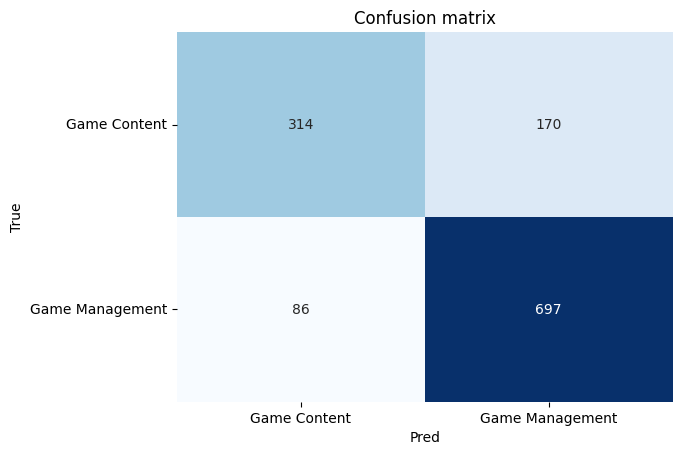

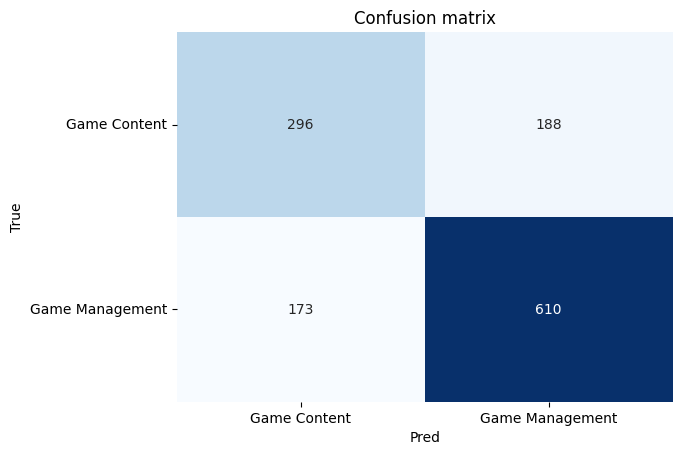

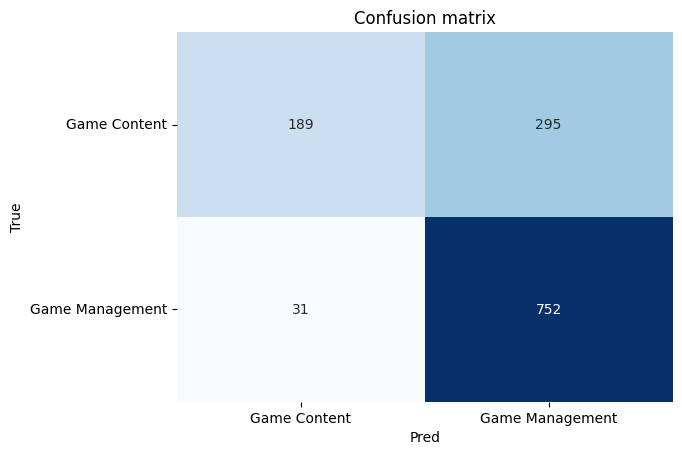

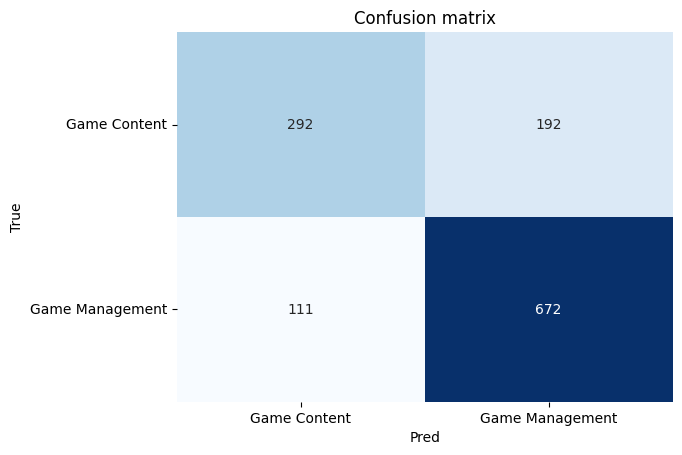

In [12]:
# 準備訓練資料
X = data["sentence"]
y = data["cluster"]
# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
vectorizer = CountVectorizer(max_features=100, stop_words="english")
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)

總體：整體模型比較能辨識類別為遊戲管理的評論，f1-score在80% 附近，優於隨機猜（50%）。(說明關於遊戲管理的主題比較集中或有明顯特徵)

關於遊戲內容的f1-score普遍偏低，代表這些留言不像遊戲管理那麼「語言風格一致」，因為關於遊戲內容的評論涉及更多面向，使模型不易分辨。


In [13]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_logistic
{'Game Content': {'f1-score': 0.7104072398190046,
                  'precision': 0.785,
                  'recall': 0.6487603305785123,
                  'support': 484.0},
 'Game Management': {'f1-score': 0.8448484848484848,
                     'precision': 0.803921568627451,
                     'recall': 0.8901660280970626,
                     'support': 783.0},
 'accuracy': 0.797947908445146,
 'macro avg': {'f1-score': 0.7776278623337447,
               'precision': 0.7944607843137255,
               'recall': 0.7694631793377875,
               'support': 1267.0},
 'weighted avg': {'f1-score': 0.7934912925878151,
                  'precision': 0.796693439806862,
                  'recall': 0.797947908445146,
                  'support': 1267.0}}


這邊使用推薦模型：Logistic Regression，整體表現最好，適合進一步調整參數或進行特徵工程強化。

### 4.4 分析可解釋模型的結果

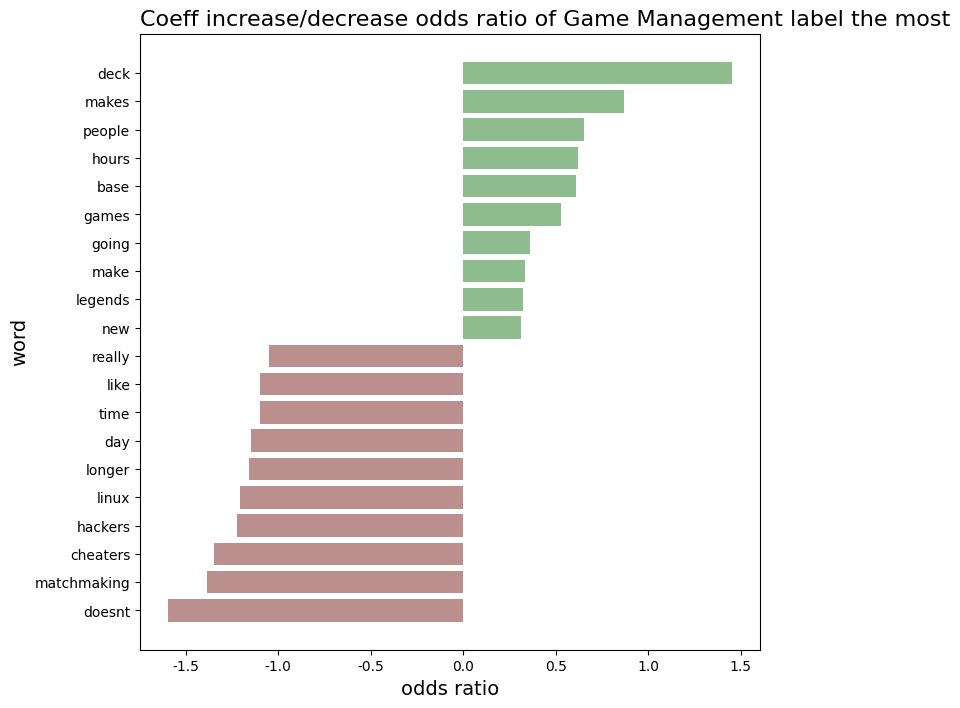

In [14]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_[[1]], index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of " + label + " label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

# plot logistic model
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

遊戲管理有些詞看不出來是管理問題，但卻被當成是判斷類別的依據，這個原因可能來自於我們使用bert做分類，它在分類時會根據上下文判斷語意，而logistic模型是用統計學方式建構，不一定等同「語意上合理」。也可能是因為遊戲管理類評論語氣與句型更一致，導致「非關鍵詞」也有用。

In [15]:
ct = pd.read_csv("D:\社媒\Apex_month.csv")
ct.dropna(inplace=True)
ct

<>:1: DeprecationWarning: invalid escape sequence '\A'
<>:1: DeprecationWarning: invalid escape sequence '\A'
C:\Users\Tak\AppData\Local\Temp\ipykernel_16536\2961366674.py:1: DeprecationWarning: invalid escape sequence '\A'
  ct = pd.read_csv("D:\社媒\Apex_month.csv")


,isRecommended,isHelpful,Content,Date
0,不推薦,687 個人認為這篇評論值得參考\n62 個人認為這篇評論很有趣 61,張貼於：3 月 19 日\nI’ve spent over 2000 hours playi...,張貼於：3 月 19 日
1,推薦,42 個人認為這篇評論值得參考\n3 個人認為這篇評論很有趣 0,"張貼於：3 月 29 日\nPlayed since release, but it die...",張貼於：3 月 29 日
2,不推薦,30 個人認為這篇評論值得參考\n10 個人認為這篇評論很有趣 0,張貼於：4 月 18 日\nThere's a lot of reasons to disl...,張貼於：4 月 18 日
3,不推薦,54 個人認為這篇評論值得參考\n5 個人認為這篇評論很有趣 0,張貼於：3 月 25 日\nintegrity error 0x8000002\nI hav...,張貼於：3 月 25 日
4,不推薦,9 個人認為這篇評論值得參考 0,張貼於：3 月 25 日\nTHE ANTI-CHEAT SYSTEM CAN'T EVEN...,張貼於：3 月 25 日
...,...,...,...,...
585,推薦,1 個人認為這篇評論值得參考\n1 個人認為這篇評論很有趣 0,張貼於：4 月 1 日\nGRAPHICS\n🔲 You forget what reali...,張貼於：4 月 1 日
586,推薦,1 個人認為這篇評論值得參考 0,"張貼於：4 月 1 日\nfirst time playing seems cool, ho...",張貼於：4 月 1 日
587,推薦,1 個人認為這篇評論值得參考 0,張貼於：3 月 31 日\nThis game is the love/hate relat...,張貼於：3 月 31 日
588,不推薦,1 個人認為這篇評論值得參考\n3 個人認為這篇評論很有趣 0,張貼於：3 月 31 日\ni get raped by teams of threeas ...,張貼於：3 月 31 日


這邊再爬出遊戲近一個月最值得參考的590條評論，看看分類器效果

In [16]:
#清理資料並統一格式
def data_cleaned(origin):
    ##將日期改為20xx-xx-xx
    origin["Date"] = origin["Date"].str.replace(r"張貼於：(\d{4}) 年 (\d{1,2}) 月 (\d{1,2}) 日", r"\1-\2-\3", regex=True)
    origin["Date"] = origin["Date"].str.replace(r"張貼於：(\d{1,2}) 月 (\d{1,2}) 日", r"2025-\1-\2", regex=True)

    ##去除評論中包含日期的部分
    origin["Content"] = origin["Content"].str.replace(r"張貼於：(\d{4}) 年 (\d{1,2}) 月 (\d{1,2}) 日\n", r"", regex=True)
    origin["Content"] = origin["Content"].str.replace(r"張貼於：(\d{1,2}) 月 (\d{1,2}) 日\n", r"", regex=True)

    ##去掉isHelpful為空值的資料，用isUseful作為新的欄位，代表有多少人覺得這篇評論有參考性
    origin = origin.dropna(subset=['isHelpful'])
    origin["isUseful"] = origin["isHelpful"].str.extract(r"([\d,]+) 個人認為這篇評論值得參考")[0].str.replace(",", "").astype(int)
    origin = origin.drop(["isHelpful"], axis=1)

    ##僅留下英文的評論
    origin = origin[origin['Content'].str.match(r'^[A-Za-z0-9\s.,!?\'"-]*$', na=False)]# 保留只包含英文字符（字母、數字、空格和標點）的行

    ##去除只有一個單字的資料
    origin = origin[origin['Content'].str.split().str.len()>1]

    return origin

test = data_cleaned(ct)

import re
#新增['sentence']欄位，用'.'取代'\n'
test['sentence'] = test['Content'].str.replace(r'\n','.', regex=True)
##保留字母、數字和空格
test["sentence"] = test["sentence"].apply(lambda x: re.sub(r'[^\w\s]','', x))

test

,isRecommended,Content,Date,isUseful,sentence
1,推薦,"Played since release, but it died on me, feels...",2025-3-29,42,Played since release but it died on me feels l...
2,不推薦,There's a lot of reasons to dislike this game....,2025-4-18,30,Theres a lot of reasons to dislike this game M...
3,不推薦,integrity error 0x8000002\nI have nothing spec...,2025-3-25,54,integrity error 0x8000002I have nothing specia...
10,不推薦,game is in a bad state right now . alot of leg...,2025-4-14,7,game is in a bad state right now alot of lege...
11,不推薦,Thank you DX12 now i can't play it anymore,2025-3-28,9,Thank you DX12 now i cant play it anymore
...,...,...,...,...,...
583,不推薦,TRASHHHHHHHHH ASSSSSSSSSS GAME,2025-4-2,1,TRASHHHHHHHHH ASSSSSSSSSS GAME
584,推薦,sniff sniff,2025-4-1,1,sniff sniff
586,推薦,"first time playing seems cool, hopefully it do...",2025-4-1,1,first time playing seems cool hopefully it doe...
588,不推薦,i get raped by teams of threeas a solo everyti...,2025-3-31,1,i get raped by teams of threeas a solo everyti...


## 5. 主題模型

### 5.1 人工給定主題的主題模型

In [17]:
anchor_content = "matchmake , aim assist, cheat, crash, play"
anchor_management = "anticheat, paid, linux, ea, respawn, battle pass"

from transformers import BertTokenizer, BertModel
import torch
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# 初始化 BERT 模型
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.pooler_output.squeeze().numpy()  # 取 [CLS] 向量

# 編碼 anchor vectors
vec_content = get_bert_embedding(anchor_content)
vec_management = get_bert_embedding(anchor_management)

def classify_comment(text):
    vec = get_bert_embedding(text)
    sim_content = cosine_similarity([vec], [vec_content])[0][0]
    sim_management = cosine_similarity([vec], [vec_management])[0][0]
    return "Game Content" if sim_content > sim_management else "Game Management"
test['cluster'] = test['sentence'].apply(classify_comment)

test

,isRecommended,Content,Date,isUseful,sentence,cluster
1,推薦,"Played since release, but it died on me, feels...",2025-3-29,42,Played since release but it died on me feels l...,Game Management
2,不推薦,There's a lot of reasons to dislike this game....,2025-4-18,30,Theres a lot of reasons to dislike this game M...,Game Content
3,不推薦,integrity error 0x8000002\nI have nothing spec...,2025-3-25,54,integrity error 0x8000002I have nothing specia...,Game Content
10,不推薦,game is in a bad state right now . alot of leg...,2025-4-14,7,game is in a bad state right now alot of lege...,Game Content
11,不推薦,Thank you DX12 now i can't play it anymore,2025-3-28,9,Thank you DX12 now i cant play it anymore,Game Management
...,...,...,...,...,...,...
583,不推薦,TRASHHHHHHHHH ASSSSSSSSSS GAME,2025-4-2,1,TRASHHHHHHHHH ASSSSSSSSSS GAME,Game Management
584,推薦,sniff sniff,2025-4-1,1,sniff sniff,Game Management
586,推薦,"first time playing seems cool, hopefully it do...",2025-4-1,1,first time playing seems cool hopefully it doe...,Game Management
588,不推薦,i get raped by teams of threeas a solo everyti...,2025-3-31,1,i get raped by teams of threeas a solo everyti...,Game Management


再次用bert對評論分類

In [18]:
X = test['sentence']
y = test['cluster']

y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())
print(classification_report(y, y_pred))

                 precision    recall  f1-score   support

   Game Content       0.88      0.43      0.58       122
Game Management       0.72      0.96      0.82       186

       accuracy                           0.75       308
      macro avg       0.80      0.70      0.70       308
   weighted avg       0.79      0.75      0.73       308



讓分類器預測，可以看到管理類效果依然不錯，遊戲內容類依舊偏低

In [19]:
test['pred'] = y_pred
test.loc[:,['sentence', 'cluster',"pred"]]

,sentence,cluster,pred
1,Played since release but it died on me feels l...,Game Management,Game Content
2,Theres a lot of reasons to dislike this game M...,Game Content,Game Management
3,integrity error 0x8000002I have nothing specia...,Game Content,Game Management
10,game is in a bad state right now alot of lege...,Game Content,Game Content
11,Thank you DX12 now i cant play it anymore,Game Management,Game Management
...,...,...,...
583,TRASHHHHHHHHH ASSSSSSSSSS GAME,Game Management,Game Management
584,sniff sniff,Game Management,Game Management
586,first time playing seems cool hopefully it doe...,Game Management,Game Content
588,i get raped by teams of threeas a solo everyti...,Game Management,Game Management


In [20]:
false_pred = test.query("cluster != pred").loc[:,['sentence', 'cluster',"pred"]]
false_pred

,sentence,cluster,pred
1,Played since release but it died on me feels l...,Game Management,Game Content
2,Theres a lot of reasons to dislike this game M...,Game Content,Game Management
3,integrity error 0x8000002I have nothing specia...,Game Content,Game Management
36,cash grab skins soft porn lore and constant cr...,Game Content,Game Management
42,Matchmaking is garbage if you are a new player...,Game Content,Game Management
...,...,...,...
544,Made me cry and go bonkers and almost end my o...,Game Content,Game Management
549,Bunch of bunnyhop scripters supported by EA An...,Game Content,Game Management
571,Personally No Very greedy company Very frustra...,Game Content,Game Management
580,this game is has nothing good left now played ...,Game Content,Game Management


觀察預測錯的評論

In [21]:
false_pred.loc[false_pred['cluster']=='Game Content', :].head(1000)

,sentence,cluster,pred
2,Theres a lot of reasons to dislike this game M...,Game Content,Game Management
3,integrity error 0x8000002I have nothing specia...,Game Content,Game Management
36,cash grab skins soft porn lore and constant cr...,Game Content,Game Management
42,Matchmaking is garbage if you are a new player...,Game Content,Game Management
44,If you enjoy playing with idiots who go AFK in...,Game Content,Game Management
...,...,...,...
528,This game has the WORST skill base MM i cant e...,Game Content,Game Management
544,Made me cry and go bonkers and almost end my o...,Game Content,Game Management
549,Bunch of bunnyhop scripters supported by EA An...,Game Content,Game Management
571,Personally No Very greedy company Very frustra...,Game Content,Game Management


找出那些被錯誤預測成遊戲管理的評論

In [22]:
pprint(false_pred['sentence'][528])

('This game has the WORST skill base MM i cant even get a 4K 20 Bomb and the '
 'game think i have the same skill capability as a X5 pred with 120K kills on '
 'rev increasing the TTK with this season lets those preds to get me back to '
 'the lobby within 5 of a second only good thing about this game is apex packs')


找出其中一條評論，根據內容判斷該評論確實屬於遊戲內容的部分

In [ ]:
df = MetaData.copy() 

### 5.2 LDA主題模型前處理

In [17]:
# 參考第九週程式碼，我們的字典需要不只 bigram 還要有單一 term
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))
stopWords.update(['thi', 'apex', 'legend', 'royal', 'still', 'game']) # 前面設的

stemmer = PorterStemmer()

# 篩選原始 df（假設欄位為 'Date', 'stem_token'）
# 移除 stopword 與過短詞
df_filtered = df[df['stem_token'].str.lower().apply(lambda w: w not in stopWords and len(w) > 1)]

# 將每篇文章的詞組合成 token list
docs_grouped = df_filtered.groupby('Date')['stem_token'].apply(list)
docs = docs_grouped.tolist()

# 建立 Bigram 模型，只保留出現次數 > 20 的 bigram
bigram_model = Phrases(docs, min_count=20)
bigram_phraser = Phraser(bigram_model)

# 將 bigram 套用到每篇文章（詞組會包含 '_')
docs_with_bigrams = [bigram_phraser[doc] for doc in docs]

# 建立 Dictionary 與 Corpus（用於 gensim 的 LDA）
dictionary = Dictionary(docs_with_bigrams)
corpus = [dictionary.doc2bow(doc) for doc in docs_with_bigrams]

# 檢查結果
print(dictionary)  # 顯示 token 數量
print("Sample doc BOW:", corpus[0])
print("Sample bigrams in dictionary:", [t for t in dictionary.token2id if '_' in t][:10])

Dictionary<3517 unique tokens: ['came', 'clariti', 'fav', 'forsaken', 'full']...>
Sample doc BOW: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]
Sample bigrams in dictionary: ['battl_pass', 'player_base', 'steam_deck', 'anti_cheat', 'linux_support', 'linux_user', 'remov_linux', 'new_battl', 'aim_assist', 'crash_crash']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\owoyi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
doc_lengths = [len(doc) for doc in docs]
print(f"平均長度: {np.mean(doc_lengths)}, 最小長度: {np.min(doc_lengths)}")
# 文件長度<5 會導致pmi數值無限大

平均長度: 70.38412698412698, 最小長度: 1


In [19]:
# 排除長度少於 5 個的詞
docs_filtered = [doc for doc in docs_with_bigrams if len(doc) >= 5]

# 重新建立 dictionary 與 corpus
dictionary = Dictionary(docs_filtered)
corpus = [dictionary.doc2bow(doc) for doc in docs_filtered]

In [20]:
#針對詞彙整類太少導式pmi 結果為inf 的排除法
## 排除過低或過高頻詞
dictionary.filter_extremes(no_below=5, no_above=0.5)
## 重建 corpus
corpus = [dictionary.doc2bow(doc) for doc in docs_filtered]

### 5.3 訓練 LDA topic model

In [21]:
t0 = time.time()

topic_num_list = np.arange(2, 16)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # 根據不同topic_num訓練LDA模型
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5
        )
    
    loss = model.log_perplexity(corpus)
    # 計算Perplexity和PMI值
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # 將結果儲存起來
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

c:\Users\owoyi\AppData\Local\Programs\Python\Python312\Lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)


花費時間: 82.55118417739868 sec


### 5.4 查看 LDA 模型指標找出最佳主題數

In [22]:
# Pointwise Mutual Information: 文字同時出現帶來特殊訊息的指標PMI越大越好
## 如果出現inf，那麼就是文件長度問題，或是詞彙種類太少
# perplexity :複雜度，數值越小越好
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,468.464314,inf
1,3,484.208843,inf
2,4,504.538217,inf
3,5,525.823643,inf
4,6,545.104380,inf
5,7,570.703818,inf
6,8,569.754667,inf
7,9,597.365908,inf
8,10,613.146615,inf
9,11,616.407925,inf


In [31]:
## 即使盡量排錯了，但難免會因語料太少，而有pmi結果為inf的情形
# 把 warning 當錯誤處理，才能抓出 PMI 出錯的點
import warnings
warnings.filterwarnings("error", category=RuntimeWarning)

start_time = time.time()

topic_range = np.arange(2, 16)
results = {"topic_num": [], "perplexity": [], "pmi": []}

for k in topic_range:
    print(f"Running LDA with {k} topics...")
    try:
        lda = LdaModel(
            corpus=corpus,
            num_topics=k,
            id2word=dictionary,
            random_state=1500,
            passes=5
        )

        ppl = np.exp(-1. * lda.log_perplexity(corpus))

        try:
            pmi_score = CoherenceModel(
                model=lda,
                texts=docs,
                dictionary=dictionary,
                coherence='c_npmi',
                window_size=20
            ).get_coherence()
        except RuntimeWarning as warn:
            print(f"PMI warning at k={k}: {warn}")
            pmi_score = float('inf')
        except Exception as err:
            print(f"PMI failed at k={k}: {err}")
            pmi_score = float('nan')

        results["topic_num"].append(k)
        results["perplexity"].append(ppl)
        results["pmi"].append(pmi_score)

    except Exception as err:
        print(f"LDA model failed at k={k}: {err}")
        continue

elapsed = round(time.time() - start_time, 2)
print(f"Done. Time: {elapsed} sec")

results_df = pd.DataFrame(results)
results_df


Running LDA with 2 topics...
PMI warning at k=2: divide by zero encountered in scalar divide
Running LDA with 3 topics...
PMI warning at k=3: divide by zero encountered in scalar divide
Running LDA with 4 topics...
PMI warning at k=4: divide by zero encountered in scalar divide
Running LDA with 5 topics...
PMI warning at k=5: divide by zero encountered in scalar divide
Running LDA with 6 topics...
PMI warning at k=6: divide by zero encountered in scalar divide
Running LDA with 7 topics...
PMI warning at k=7: divide by zero encountered in scalar divide
Running LDA with 8 topics...
PMI warning at k=8: divide by zero encountered in scalar divide
Running LDA with 9 topics...
PMI warning at k=9: divide by zero encountered in scalar divide
Running LDA with 10 topics...
PMI warning at k=10: divide by zero encountered in scalar divide
Running LDA with 11 topics...
PMI warning at k=11: divide by zero encountered in scalar divide
Running LDA with 12 topics...
PMI warning at k=12: divide by zero 

,topic_num,perplexity,pmi
0,2,468.464314,inf
1,3,484.208843,inf
2,4,504.538217,inf
3,5,525.823643,inf
4,6,545.104380,inf
5,7,570.703818,inf
6,8,569.754667,inf
7,9,597.365908,inf
8,10,613.146615,inf
9,11,616.407925,inf


<Axes: xlabel='topic_num'>

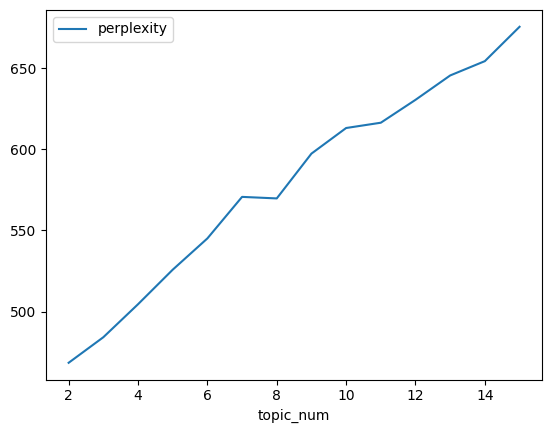

In [34]:
result.plot.line(x='topic_num', y='perplexity')

In [24]:
model = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 1500,
    passes=5
    )

### 5.5 視覺化呈現

In [25]:

pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.027042  0.044593       1        1  49.700802
3      0.000946  0.014496       2        1  20.799240
1      0.076037 -0.013961       3        1  20.095104
2     -0.049940 -0.045128       4        1   9.404854, topic_info=              Term        Freq       Total Category  logprob  loglift
356          linux  131.000000  131.000000  Default  30.0000  30.0000
10             get  191.000000  191.000000  Default  29.0000  29.0000
265        support  112.000000  112.000000  Default  28.0000  28.0000
357  linux_support   56.000000   56.000000  Default  27.0000  27.0000
90            like  169.000000  169.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
81            hour    7.625457   62.970489   Topic4  -5.3015   0.2528
247         server    8.211686  109.790470   Topic4  -5.2275  -0.2291
231         player    8.571371  185.734774   Topic4  -5.1846  -0.7119
125            tri    7.292813   50.485277   Topic4  -5.3461   0.4292
356          linux    7.899323  131.803707   Topic4  -5.2662  -0.4506

[278 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
656       1  0.175833   2019
656       3  0.527499   2019
656       4  0.175833   2019
38        2  0.121450    3rd
38        3  0.607252    3rd
...     ...       ...    ...
457       4  0.101353  wrong
643       1  0.815112   youd
133       1  0.137871  youll
133       3  0.275742  youll
133       4  0.413614  youll

[657 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

In [26]:
pyLDAvis.save_html(p, "lda_en.html")

In [27]:
# 取得每章的主題分佈
topics_doc = model.get_document_topics(corpus)

In [28]:
# 將gensim的表示法轉成稀疏矩陣
m_theta = corpus2csc(topics_doc).T.toarray()
theta = pd.DataFrame(m_theta, columns=[f"topic_{i+1}" for i in range(m_theta.shape[1])])
theta

,topic_1,topic_2,topic_3,topic_4
0,0.026430,0.027530,0.233493,0.712547
1,0.524400,0.037852,0.037787,0.399961
2,0.010376,0.010207,0.969093,0.010324
3,0.020386,0.019975,0.939591,0.020048
4,0.000000,0.000000,0.978144,0.017457
...,...,...,...,...
267,0.000000,0.000000,0.000000,0.984192
268,0.055462,0.837334,0.052686,0.054518
269,0.016929,0.016675,0.016529,0.949867
270,0.044441,0.042977,0.043573,0.869008


<Axes: >

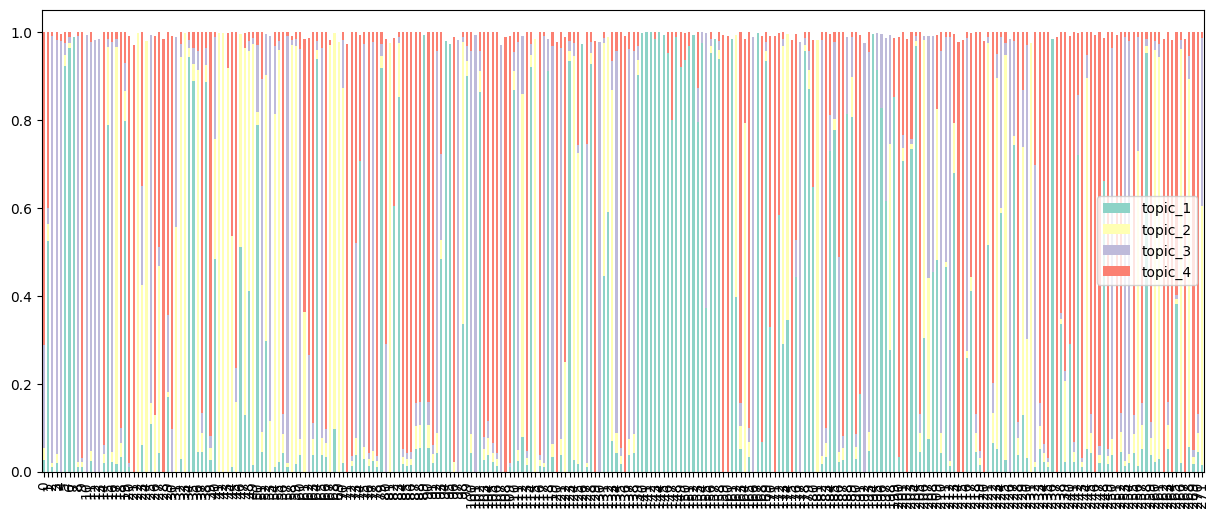

In [29]:
# 主題分布視覺化
fig, ax = plt.subplots(figsize=(15, 6))
theta.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)

## 結論
- 透過字詞共現圖與LDA主題模型，可以觀察到玩家對於Apex近一年的討論內容偏向於battle pass(遊戲通行證)、matchmaking(排位機制)、cheat and anticheat、平台支援上面，遊戲人數下降的原因可能受這些議題影響

- 根據這些議題，我們用bert將評論分類成遊戲內容與遊戲管理並訓練分類器，利用此分類器能幫助分析者查看遊戲中的議題是甚麼，並透過議題找問題。讓分析者知道玩家最近在乎的點是遊戲的內容還是遊戲的營運，並讓分析者知道應該從哪邊解決問題

## 困難點與不足
- 我們選取的資料集缺少合適的分類標籤，一開始是以用戶對遊戲推薦與不推薦作為分類標籤，但是遇到了資料嚴重不平衡的問題(不推薦比推薦約為10:1 )而放棄使用
- bert的分類產生的標籤並非真正的ground truth，會有評論被分在錯誤的標籤，從而影響分類效果
- 分類器的解釋性圖表比較不像在解釋Logistic Regression的分類依據，而像是在解釋bert



